In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from local_utils import *

from intro import *

In [2]:
import pickle
with open(f"./outputs/solution_1.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

# Map the data points to their averages at the center of the grid.

noise level:0.05, A amplitude:7.7918916091600305, B amplitude:2.4416399323053968, C amplitude:0.1944871023210739,
A noise std:0.38959458045800155, B noise std:0.12208199661526985, C noise std:0.009724355116053697.


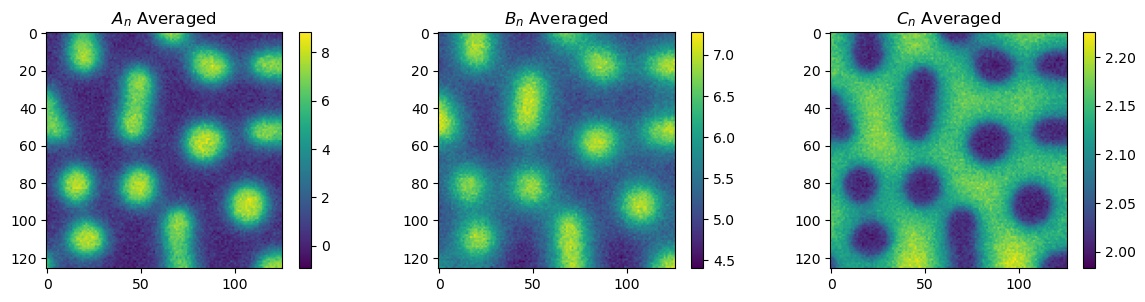

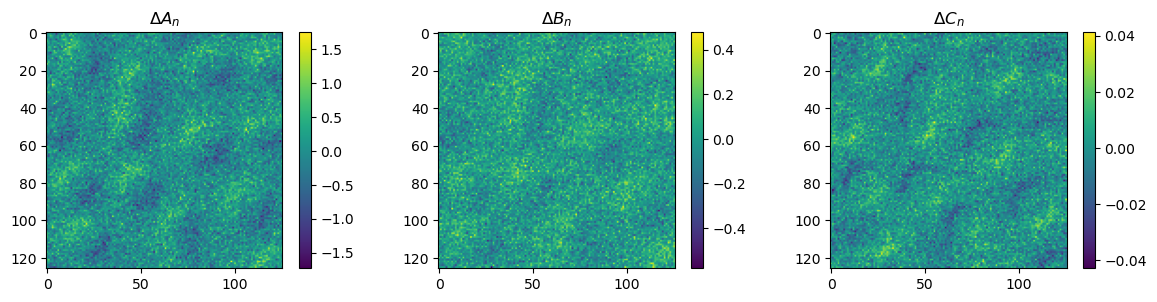

In [3]:
A_n = solution[1, 0, :, :]
B_n = solution[1, 1, :, :]
C_n = solution[1, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(1,-1, 1)
y_slice = slice(1,-1, 1)

to = create_to(A_n[x_slice,y_slice])

########################################
# Take the average of data points
kernel =np.array([[1, 1],
                  [1, 1]])


A_n = ndimage.convolve(A_n, kernel)/4
B_n = ndimage.convolve(B_n, kernel)/4
C_n = ndimage.convolve(C_n, kernel)/4

######################################
# Add noise to averaged meshd
noise_level = 0.05
ampA = np.max(A_n) - np.min(A_n)
ampB = np.max(B_n) - np.min(B_n)
ampC = np.max(C_n) - np.min(C_n)
print(f"noise level:{noise_level}, A amplitude:{ampA}, B amplitude:{ampB}, C amplitude:{ampC},")
print(f"A noise std:{ampA*noise_level}, B noise std:{ampB*noise_level}, C noise std:{ampC*noise_level}.")
np.random.seed(42)
A_n += np.random.normal(0,ampA*noise_level ,A_n.shape)
B_n += np.random.normal(0,ampB*noise_level ,B_n.shape)
C_n += np.random.normal(0,ampC*noise_level ,C_n.shape)

plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$ Averaged", r"$B_{n}$ Averaged", r"$C_{n}$ Averaged"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([A_n[x_slice,y_slice]-solution[1, 0, x_slice,y_slice],
           B_n[x_slice,y_slice]-solution[1, 1, x_slice,y_slice],
           C_n[x_slice,y_slice]-solution[1, 2, x_slice,y_slice]], 
          [r"$\Delta A_{n}$", r"$\Delta B_{n}$", r"$\Delta C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

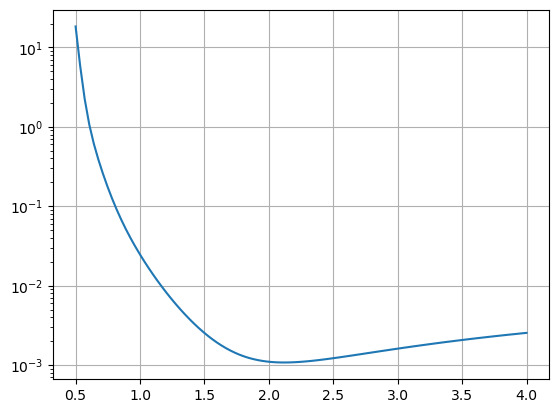

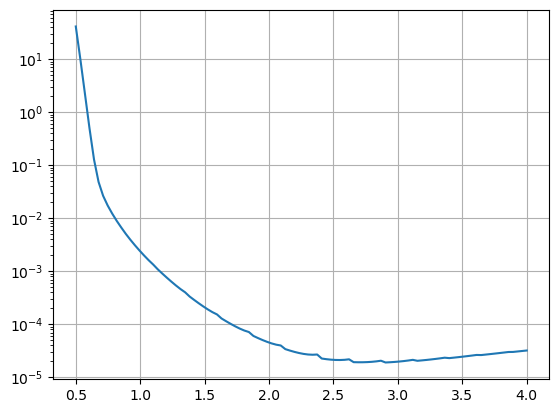

In [4]:
A_n_test2 = grad_diff(solution[1, 0, :,:])[x_slice,y_slice]
B_n_test2 = grad_diff(solution[1, 1, :,:])[x_slice,y_slice]

ss = np.linspace(5e-1, 4, 100)
stds_A= np.array([ np.mean( (ndimage.gaussian_laplace(A_n, sigma=s)[x_slice,y_slice]-A_n_test2)**2) 
                 for s in ss])
stds_B= np.array([ np.mean( (ndimage.gaussian_laplace(B_n, sigma=s)[x_slice,y_slice]-B_n_test2)**2) 
                 for s in ss])

plt.plot(ss, stds_A);plt.grid();plt.yscale('log');plt.show()
plt.plot(ss, stds_B);plt.grid();plt.yscale('log');plt.show()

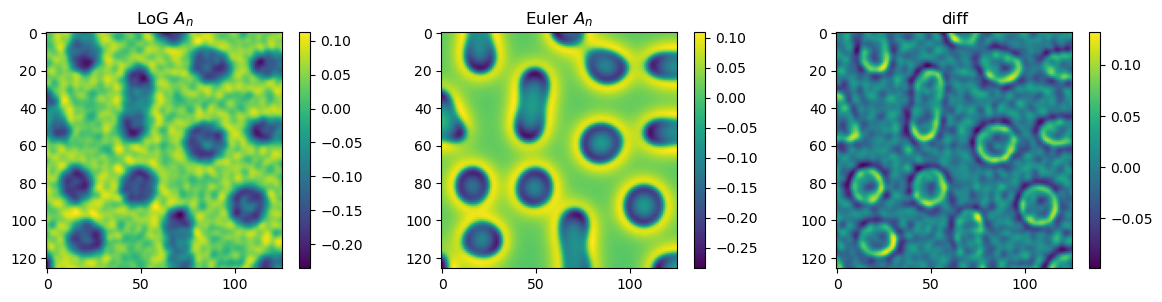

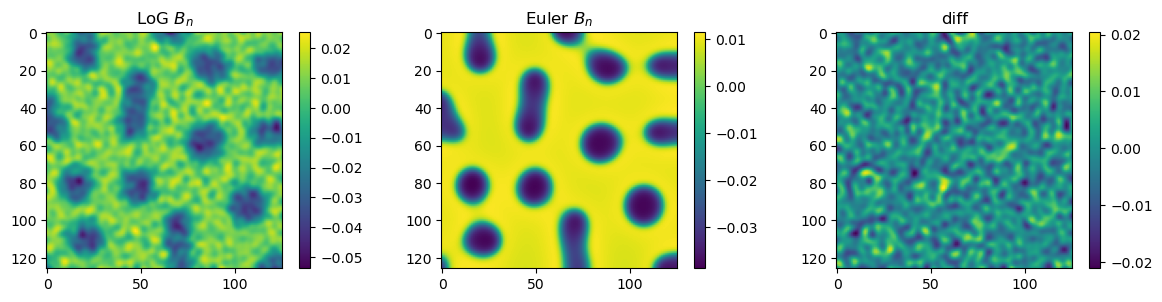

In [5]:
A_n_test = ndimage.gaussian_laplace(A_n, sigma=2.2)[x_slice,y_slice]
A_n_test2 = grad_diff(solution[1, 0, :,:])[x_slice,y_slice]

B_n_test = ndimage.gaussian_laplace(B_n, sigma=2.2)[x_slice,y_slice]
B_n_test2 = grad_diff(solution[1, 1, :,:])[x_slice,y_slice]
plot_n_im([A_n_test, A_n_test2,A_n_test-A_n_test2 ], 
          [r"LoG $A_{n}$", r"Euler $A_{n}$ ", "diff"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([B_n_test, B_n_test2,B_n_test-B_n_test2], 
          [r"LoG $B_{n}$", r"Euler $B_{n}$ ", "diff"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

In [6]:
#torch.manual_seed(42)
np.random.seed(42)

def run(device_index):
    import numpy as np
    import torch
    import torch.nn as nn
    import sys
    import pathlib
    from pathlib import Path
    sys.path.append(f"{Path.home()}/morpho_repo")
    sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
    
    from pinns import Net_dense_normalised, Laplacian
    
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    
    device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")
    dev_str = f"{device.type}:{device.index}"
        
    ###########################################################
    # Inputs
    # restrict to inner boundaries
    x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
    y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
    X,Y = torch.meshgrid(x, y, indexing='ij')
    data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)
    ##########################################################
    #   Data
    # restrict to inner boundaries
    data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
    data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
    data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
    ###########################################################
    # LoG diffusion instead of Laplacians
    # First, find the Laplacian of the Gaussian on the whole domain,
    # then, select the inner boundaries. This way, the boundaries 
    # effets removed
    diffusion_scale_factor = (run_params.Ix*run_params.Jy/(run_params.Lx*run_params.Ly))
    laplacianA = diffusion_scale_factor * ndimage.gaussian_laplace(A_n, sigma=2.2)
    laplacianB = diffusion_scale_factor * ndimage.gaussian_laplace(B_n, sigma=2.2)

    laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
    laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
    ###########################################################
    # Model
    lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
    ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
    model = Net_dense_normalised([2, 128, 128, 128, 3], lb, ub).to(device)
    ###########################################################
    # optimizer
    optimizer = torch.optim.LBFGS([*model.parameters()], lr=1
                                 ,line_search_fn='strong_wolfe')#.Adam([*model.parameters()], lr=1e-3)#

    ###########################################################
    # Train/Validation splits
    #

    # Data
    max_index = data_X.shape[0]
    All_indices = torch.randperm(max_index)
    train_indices = All_indices[:max_index//16]#All_indices[:5*max_index//6]
    validation_indices = All_indices[max_index//16:]#All_indices[5*max_index//6:]


    data_X_train = data_X[train_indices,:]
    data_X_validation = data_X[validation_indices,:]
    data_A_train = data_A[train_indices]
    data_A_validation = data_A[validation_indices]
    data_B_train = data_B[train_indices]
    data_B_validation = data_B[validation_indices]
    data_C_train = data_C[train_indices]
    data_C_validation = data_C[validation_indices]

    # Laplacian
    max_Laplacian_index = laplacianA.shape[0]
    All_Laplacian_indices = torch.randperm(max_Laplacian_index)
    train_Laplacian_indices = All_Laplacian_indices[:max_Laplacian_index//16]#[:5*max_Laplacian_index//6]
    validation_Laplacian_indices = All_Laplacian_indices[max_Laplacian_index//16:]#[5*max_Laplacian_index//6:]

    laplacianA_train = laplacianA[train_Laplacian_indices].to(device)
    laplacianA_validation = laplacianA[validation_Laplacian_indices].to(device)
    laplacianB_train = laplacianB[train_Laplacian_indices].to(device)
    laplacianB_validation = laplacianB[validation_Laplacian_indices].to(device)

    epochs = 3000
    loss_data = 0.0
    lambda_data = 1.0
    loss_physics = 0.0
    lambda_physics_laplacian = 1e-2

    losses = np.zeros((5, epochs))
    validations = np.zeros(epochs)

    def act(x, km, n=2):
        return x**n / (x**n + km**n)

    def inh(x, km, n=2):
        return  km**n / (x**n + km**n)


    for i in range(epochs):
        
        def find_data_losses(data_X_input, data_A, data_B, data_C):
            #################################
            # data loss       
            data_f_hat = model(data_X_input).squeeze() 
            data_A_hat = data_f_hat[:,0]
            data_B_hat = data_f_hat[:,1]
            data_C_hat = data_f_hat[:,2]
            loss_A_data = torch.mean((data_A - data_A_hat)**2)
            loss_B_data = torch.mean((data_B - data_B_hat)**2)
            loss_C_data = torch.mean((data_C - data_C_hat)**2)
            return (loss_A_data,loss_B_data,loss_C_data)

        def find_Laplacian_losses(data_X_input, laplacianA, laplacianB,
                                  laplacian_indices):
            #################################
            # physics derivatives
            #        
            physics_f = model(data_X_input).squeeze()         
            A_hat = physics_f[:,0]
            B_hat = physics_f[:,1]        
            # Note: The Laplacian is taken first on all points
            #       and then are selected for the given index
            #       The reason to do it this way is becuase of
            #       The laplacian bounderies effect that we need to remove
            laplacianA_hat = Laplacian(A_hat, data_X_input)
            laplacianB_hat = Laplacian(B_hat, data_X_input)

            laplacianA_hat = laplacianA_hat[laplacian_indices]
            laplacianB_hat = laplacianB_hat[laplacian_indices]

            A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
            B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)                 
            ###############################
            return (A_loss_laplacian, B_loss_laplacian)

        # L-BFGS
        def closure():

            optimizer.zero_grad()
            (loss_A_data,loss_B_data,loss_C_data
            ) = find_data_losses(data_X_train,data_A_train,data_B_train,data_C_train)

            (A_loss_laplacian, B_loss_laplacian
            ) = find_Laplacian_losses(data_X, laplacianA_train,laplacianB_train,
                                      train_Laplacian_indices)

            loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
            loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
            total_loss = (
                +lambda_data*loss_data            
                +lambda_physics_laplacian*loss_laplacian_physics
                            )

            total_loss.backward(retain_graph=True)


            losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                           A_loss_laplacian.item(), B_loss_laplacian.item())                    

            return total_loss

        optimizer.step(closure)

        (validation_A_data,validation_B_data,validation_C_data,
         ) = find_data_losses(data_X_validation, 
                              data_A_validation,data_B_validation,data_C_validation)

        (A_validation_laplacian, B_validation_laplacian
        ) = find_Laplacian_losses(data_X, laplacianA_validation, laplacianB_validation,
                                  validation_Laplacian_indices)

        validation_loss = (validation_A_data+validation_B_data+validation_C_data+
                           A_validation_laplacian+B_validation_laplacian).item()
        validations[i] = validation_loss
        # Early stop
        w = 50
        if i > w:
            if validations[i] > moving_average(validations[:i], w)[-1]:
                break
            
    return (model, losses, validations, train_indices, validation_indices, 
            train_Laplacian_indices, validation_Laplacian_indices)                

In [ ]:
from multiprocessing import Pool

run_parameters = [0, 1, 2]*6


with Pool(18) as pool:
    results = pool.map(run, run_parameters)

In [ ]:
for run_items in results:    
    plt.plot(run_items[2][:np.argwhere(run_items[2] == 0)[0][0]])
plt.yscale('log')

In [ ]:
for run_items in results:
    losses = np.sum(run_items[1], axis=0)    
    plt.plot(losses[:np.argwhere(losses == 0)[0][0]])
plt.yscale('log')

In [ ]:
def plot_one(model, device_index):
    device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")
    dev_str = f"{device.type}:{device.index}"
    x = torch.linspace(0, run_params.Lx, run_params.Ix).to(device)
    y = torch.linspace(0, run_params.Ly, run_params.Jy).to(device)
    X,Y = torch.meshgrid(x, y, indexing='ij')
    data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

    physics_f = model(data_X).squeeze()
    A = physics_f[:,0]
    B = physics_f[:,1]
    C = physics_f[:,2]
    dxy  = torch.autograd.grad(A, data_X, torch.ones_like(A), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, data_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, data_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianA = dx2 + dy2

    dxy  = torch.autograd.grad(B, data_X, torch.ones_like(B), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, data_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, data_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianB = dx2 + dy2

    A = A.cpu().detach().numpy().reshape((128,128))
    B = B.cpu().detach().numpy().reshape((128,128))
    C = C.cpu().detach().numpy().reshape((128,128))
    laplacianA = laplacianA.cpu().detach().numpy().reshape((128,128))[1:-1, 1:-1]
    laplacianB = laplacianB.cpu().detach().numpy().reshape((128,128))[1:-1, 1:-1]

    A_actual = solution[1, 0, :, :]
    B_actual = solution[1, 1, :, :]
    C_actual = solution[1, 2, :, :]

    laplacianA2 = ((128**2)/(10**2))* grad_diff(A_actual)[1:-1, 1:-1]
    laplacianB2 = ((128**2)/(10**2))* grad_diff(B_actual)[1:-1, 1:-1]

    n = params["n"]

    F_C =  params["b_C"] + params["V_C"]*inh(A_actual, params["K_AC"], n)*inh(B_actual, params["K_BC"], n)*act(C_actual, params["K_CC"], n) - params["mu_C"] * C_actual
    F_C2 =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
    F_A =  params["b_A"] + params["V_A"]*act(A_actual, params["K_AA"], n)*inh(B_actual, params["K_BA"], n) - params["mu_A"] * A_actual
    F_A2 =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
    F_B =  params["b_B"] + params["V_B"]*act(A_actual, params["K_AB"], n)*inh(C_actual, params["K_CB"], n) - params["mu_B"] * B_actual
    F_B2 =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B

    dAdt_actual = params["D_A"]*laplacianA+F_A[1:-1, 1:-1]
    dAdt = params["D_A"]*laplacianA2+F_A2[1:-1, 1:-1]
    dBdt_actual = params["D_B"]*laplacianB+F_B[1:-1, 1:-1]
    dBdt = params["D_B"]*laplacianB2+F_B2[1:-1, 1:-1]

    print(f"A diff:{np.mean((A-A_actual)**2)}\n",
          f"B diff:{np.mean((B-B_actual)**2)}\n",
          f"C diff:{np.mean((C-C_actual)**2)}")

#     print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A2**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A2)**2))}")
#     print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B2**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B2)**2))}")
#     print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C2**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C2)**2))}")


#     print()
#     print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA-laplacianA2)**2))}")
#     print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB-laplacianB2)**2))}")

#     print()
#     print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt_actual-dAdt)**2))}")
#     print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt_actual-dBdt)**2))}")
#     print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C2)**2))}")

#     plot_n_im([A, B, C], 
#               ["A", "B", "C"],          
#               figsize=(12, 3)); plt.tight_layout();plt.show()


#     plot_n_im([laplacianA, laplacianB], 
#               ["Laplacian A", "Laplacian B"],          
#               figsize=(12, 3)); plt.tight_layout();plt.show()

#     plot_n_im([laplacianA2, laplacianB2], 
#               ["Laplacian actual A", "Laplacian actual B"],          
#               figsize=(12, 3)); plt.tight_layout();plt.show()

#     plot_n_im([laplacianA-laplacianA2, laplacianB-laplacianB2], 
#               ["Laplacian diff A", "Laplacian diff B"],          
#               figsize=(12, 3)); plt.tight_layout();plt.show()


In [ ]:
import torch
import torch.nn as nn

for i, (device_index, run_items) in enumerate(zip(run_parameters, results)):
    print("="*50)
    print(i+1)
    print()
    plot_one(run_items[0], device_index)

In [ ]:
def get_values(model, device_index):
    device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")
    dev_str = f"{device.type}:{device.index}"
    x = torch.linspace(0, run_params.Lx, run_params.Ix).to(device)
    y = torch.linspace(0, run_params.Ly, run_params.Jy).to(device)
    X,Y = torch.meshgrid(x, y, indexing='ij')
    data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)

    physics_f = model(data_X).squeeze()
    A = physics_f[:,0]
    B = physics_f[:,1]
    C = physics_f[:,2]
    dxy  = torch.autograd.grad(A, data_X, torch.ones_like(A), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, data_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, data_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianA = dx2 + dy2

    dxy  = torch.autograd.grad(B, data_X, torch.ones_like(B), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, data_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, data_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacianB = dx2 + dy2

    A = A.cpu().detach().numpy().reshape((128,128))
    B = B.cpu().detach().numpy().reshape((128,128))
    C = C.cpu().detach().numpy().reshape((128,128))
    laplacianA = laplacianA.cpu().detach().numpy().reshape((128,128))[1:-1, 1:-1]
    laplacianB = laplacianB.cpu().detach().numpy().reshape((128,128))[1:-1, 1:-1]

    A_actual = solution[1, 0, :, :]
    B_actual = solution[1, 1, :, :]
    C_actual = solution[1, 2, :, :]

    laplacianA2 = ((128**2)/(10**2))* grad_diff(A_actual)[1:-1, 1:-1]
    laplacianB2 = ((128**2)/(10**2))* grad_diff(B_actual)[1:-1, 1:-1]

    n = params["n"]

    F_C =  params["b_C"] + params["V_C"]*inh(A_actual, params["K_AC"], n)*inh(B_actual, params["K_BC"], n)*act(C_actual, params["K_CC"], n) - params["mu_C"] * C_actual
    F_C2 =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
    F_A =  params["b_A"] + params["V_A"]*act(A_actual, params["K_AA"], n)*inh(B_actual, params["K_BA"], n) - params["mu_A"] * A_actual
    F_A2 =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
    F_B =  params["b_B"] + params["V_B"]*act(A_actual, params["K_AB"], n)*inh(C_actual, params["K_CB"], n) - params["mu_B"] * B_actual
    F_B2 =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B

    dAdt_actual = params["D_A"]*laplacianA+F_A[1:-1, 1:-1]
    dAdt = params["D_A"]*laplacianA2+F_A2[1:-1, 1:-1]
    dBdt_actual = params["D_B"]*laplacianB+F_B[1:-1, 1:-1]
    dBdt = params["D_B"]*laplacianB2+F_B2[1:-1, 1:-1]
    return (np.sqrt(np.mean((A-A_actual)**2)), np.sqrt(np.mean((B-B_actual)**2)),np.sqrt(np.mean((C-C_actual)**2)),
            np.sqrt(np.mean((F_A - F_A2)**2)), np.sqrt(np.mean((F_B - F_B2)**2)), np.sqrt(np.mean((F_C - F_C2)**2)),
            np.sqrt(np.mean((dAdt_actual-dAdt)**2)),np.sqrt(np.mean((dBdt_actual-dBdt)**2)),np.sqrt(np.mean((F_C-F_C2)**2)),
            np.sqrt(np.mean((laplacianA-laplacianA2)**2)),np.sqrt(np.mean((laplacianB-laplacianB2)**2)))

In [ ]:
diffs = [get_values(run_items[0], device_index) for device_index, run_items in zip(run_parameters, results)]

In [ ]:
for i, (device_index, run_items) in enumerate(zip(run_parameters, results)):
    print(i+1,":",run_items[2][-1])

In [ ]:
for i, r in enumerate(diffs):
    #if i+1 not in [2,3,6,9]:
    #    continue
    print(i+1,":", r[9:])

In [ ]:
def find_parameters(model, device_index):
    device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() else "cpu")
    dev_str = f"{device.type}:{device.index}"
    x = torch.linspace(0, run_params.Lx, run_params.Ix).to(device)
    y = torch.linspace(0, run_params.Ly, run_params.Jy).to(device)
    X,Y = torch.meshgrid(x, y, indexing='ij')
    data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)
    
    def create_var(init=None):
        if init is None:
            return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
        else:
            return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str))


    D_A=params["D_A"]#, sampled_D_A, sampled_D_A_grad = create_var()
    D_B=params["D_B"]#, sampled_D_B, sampled_D_B_grad = create_var()
    b_A = create_var()
    b_B = create_var()
    b_C = create_var()
    V_A = create_var()
    V_B = create_var()
    V_C = create_var()
    mu_A = create_var()
    mu_B = create_var()
    mu_C=params["D_A"]#, sampled_mu_C, sampled_mu_C_grad = create_var()
    K_AA = create_var()
    K_AB = create_var()
    K_AC = create_var()
    K_BA = create_var()
    K_BC = create_var()
    K_CB = create_var()
    K_CC = create_var()
    n = params['n']

    params_name_list = [#"D_A", "D_B", 
                        "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                        "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                        "K_CC"
    ]

    params_list = [#D_A, D_B, 
                   b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
                   K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
                   K_CC
    ]
    
    def physics_loss():            
        #physics_X = torch.rand((N,2), requires_grad=True, device=dev_str)*domain_bounds
        #physics_f = model(physics_X).squeeze()
        physics_f = model(data_X).squeeze()
        A = physics_f[:,0]
        B = physics_f[:,1]
        C = physics_f[:,2]

        dxy  = torch.autograd.grad(A, data_X, torch.ones_like(A), create_graph=True)[0]# computes dy/dx
        dx, dy = dxy[:,0], dxy[:,1]
        dxy2 = torch.autograd.grad(dx, data_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
        dx2 =  dxy2[:,0]
        dyx2 = torch.autograd.grad(dy, data_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
        dy2 =  dyx2[:,1]
        laplacianA = dx2 + dy2

        dxy  = torch.autograd.grad(B, data_X, torch.ones_like(B), create_graph=True)[0]# computes dy/dx
        dx, dy = dxy[:,0], dxy[:,1]
        dxy2 = torch.autograd.grad(dx, data_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
        dx2 =  dxy2[:,0]
        dyx2 = torch.autograd.grad(dy, data_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
        dy2 =  dyx2[:,1]
        laplacianB = dx2 + dy2
        # To make sure the parameters stay positive, we use the exponential function    
        e = torch.exp
        F_A =  e(b_A) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n) - e(mu_A) * A
        #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
        F_B =  e(b_B) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n) - e(mu_B) * B
        #f_B =  e(b_B)/(e(D_B)+1e-6) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n)/(e(D_B)+1e-6) - e(mu_B)*B/(e(D_B)+1e-6)
        F_C =  e(b_C) + e(V_C)*inh(A, e(K_AC), n)*inh(B, e(K_BC), n)*act(C, e(K_CC), n) - mu_C * C


        #dAdt = e(D_A) * laplacianA + F_A
        dAdt = D_A * laplacianA + F_A
        #dAdt2 = laplacianA + f_A
        #dBdt = e(D_B) * laplacianB + F_B
        dBdt = D_B * laplacianB + F_B
        #dBdt2 = laplacianB + f_B
        dCdt = F_C
        ################################
        # physics loss
        # Construct the physics loss here
        A_loss_physics = torch.mean(dAdt**2)
        #A2_loss_physics = torch.mean(dAdt2**2)
        B_loss_physics = torch.mean(dBdt**2)
        #B2_loss_physics = torch.mean(dBdt2**2)
        C_loss_physics = torch.mean(dCdt**2)
        return (A_loss_physics #+ A2_loss_physics 
                        + B_loss_physics #+ B2_loss_physics 
                        + C_loss_physics)



    optimizer2 = torch.optim.LBFGS(params_list,
                                   lr=1,
                                   history_size=10, 
                                   max_iter=30, 
                                   line_search_fn="strong_wolfe")

    # L-BFGS
    def closure():
        if torch.is_grad_enabled():
            optimizer2.zero_grad()
        loss = physics_loss()
        if loss.requires_grad:
            loss.backward()
        return loss

    history_lbfgs = []
    stored_parameters = np.zeros(len(params_list))
    for i in range(50):
        history_lbfgs.append(physics_loss().item())
        if np.any([np.isnan(np.exp(p.item())) for p in params_list]):
            print("NAN")
            #break
            return None
        if np.any([np.isinf(np.exp(p.item())) for p in params_list]):
            print("INF")
            #break
            return None
        else:
            stored_parameters = [np.exp(p.item()) for p in params_list]
            
        optimizer2.step(closure)    
        if i%1 ==0:
            print(history_lbfgs[-1],", ".join([f"{name}={np.exp(l.item()):.4f}" 
                     for l, name in zip(params_list, params_name_list)]))
            print()
    estimated_params = {}
    for l, name in zip(stored_parameters, params_name_list):    
        estimated_params[name] =l
        
    return estimated_params


In [ ]:
estimated_parames_list = []
for device_index, run_items in zip(run_parameters, results):
    print("="*50)
    estimated_parames_list.append(find_parameters(run_items[0], device_index))

In [ ]:
for i, params_list in enumerate(estimated_parames_list):
    #if i+1 not in [2,3,9]:
    #    continue
    if params_list is None:
        continue
    print(i+1, "  ",", ".join([f"{name}={l:.4f}" 
                               for (name, l) in params_list.items()]))
    print()

In [ ]:
{'b_A': 0.001, 'b_B': 1.0, 'b_C': 20.0, 'V_A': 5.0, 'V_B': 10.0, 'V_C': 100.0, 'mu_A': 0.1, 'mu_B': 0.5,
'K_AA': 5.0, 'K_AB': 5.0, 'K_AC': 5.0, 'K_BA': 5.0, 'K_BC': 5.0, 'K_CB': 10.0, 'K_CC': 5.0}

In [ ]:

def simulate(args):
    import sys
    import pathlib
    from pathlib import Path
    sys.path.append(f"{Path.home()}/morpho_repo")
    sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
    
    from turing.three_nodes_circuits import create_circuit_3954
    from pde_solvers.cn import RD_2D_1st_Order,Neumann_Boundary_2D
    params, A_init, B_init, C_init = args
    model_128_10 = RD_2D_1st_Order(Ds=[params["D_A"], params["D_B"], 0], 
                               delta_t=100/5000, 
                               Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D
                               #boundary_condition=Periodic_Boundary_2D
                               # boundary_condition=Diritchlet_Boundary_2D
                               )
    kinetics = create_circuit_3954(params["n"],params["b_A"], params["mu_A"], params["V_A"], 
                               params["K_AA"], params["K_AB"], params["K_AC"],
                               params["b_B"], params["mu_B"], params["V_B"], 
                               params["K_BA"], params["K_BC"],
                               params["b_C"], params["mu_C"], params["V_C"], 
                               params["K_CB"], params["K_CC"])
    solution = model_128_10.integrate([A_init, B_init, C_init],kinetics, 20*5000, record_steps=5000*10)
    return solution

In [ ]:
run_parameters = [({'D_A':params['D_A'], 'D_B':params['D_B'], 'n':params['n'],
                    'mu_C':params['mu_C'],
                     **params_list}, 
                   solution[0, 0, :, :].flatten(),
                   solution[0, 1, :, :].flatten(),
                   solution[0, 2, :, :].flatten()) for i, params_list in enumerate(estimated_parames_list)
                   if params_list is not None
                  ]


In [ ]:
with Pool(9) as pool:
    results_solutions = pool.map(simulate, run_parameters)

In [ ]:
for i, sol in enumerate(results_solutions):
    print(i)
    plot_n_im([sol[-1, 0, :].reshape((128,128)),
               sol[-1, 1, :].reshape((128,128)),
               sol[-1, 2, :].reshape((128,128))], 
              ["A", "B", "C"],          
              figsize=(12, 3)); plt.tight_layout();plt.show()
    

In [ ]:
corrects = [1,4,5,6,7,8,10,12,13,14]#[1, 2, 8, 9, 10, 11, 14, 15, 17]

In [ ]:
from itertools import permutations
mu_c_val= params["mu_C"]
def to_ndarray(params):
    return np.array([params["b_A"], params["mu_A"], params["V_A"],
                             params["K_AA"], params["K_AB"], params["K_AC"],
                             params["b_B"], params["mu_B"], params["V_B"],
                             params["K_AB"], params["K_BC"], 
                             params["b_C"],  mu_c_val, params["V_C"], 
                             params["K_CB"], params["K_CC"]])

all_estimated_params = np.array([to_ndarray(p) for p in estimated_parames_list
                                  if p is not None])

In [ ]:
import pandas as pd
names = ["b_A","mu_A","V_A","K_AA","K_AB","K_AC",
         "b_B","mu_B","V_B","K_BA","K_BC",
         "b_C","mu_C","V_C","K_CB","K_CC"]

df = pd.DataFrame(all_estimated_params, columns=names)

In [ ]:
df["K_CC"]

In [ ]:
{'b_A': 0.001, 'b_B': 1.0, 'b_C': 20.0, 'V_A': 5.0, 'V_B': 10.0, 'V_C': 100.0, 'mu_A': 0.1, 'mu_B': 0.5,
'K_AA': 5.0, 'K_AB': 5.0, 'K_AC': 5.0, 'K_BA': 5.0, 'K_BC': 5.0, 'K_CB': 10.0, 'K_CC': 5.0}

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(all_estimated_params)

In [ ]:
plt.figure()
index_1 = 2
index_2 = 3
for i,comp in enumerate(principalComponents):    
    plt.scatter(
        comp[index_1], comp[index_2], 
        color= 'blue' if i in corrects else 'red', 
        alpha=0.8, lw=lw
    )

In [ ]:
from itertools import permutations
distances = np.array([(i,j,np.linalg.norm(p1-p2))
                      for (i,p1), (j,p2) in  
                      permutations(zip(range(principalComponents.shape[0]), principalComponents), 2)])
distances = sorted(distances, key=lambda x: x[2])

In [ ]:
for i,j,distance in distances:
    plt.scatter(i,j, marker='o', color='blue' if i in corrects else 'red', s=np.exp(2/distance))
plt.xlim([0,17])
plt.xticks(range(1,19))
plt.ylim([0,17])
plt.yticks(range(1,19))
plt.show()

In [ ]:
plt.hist(list(map(lambda x: x[2], [ item for item in distances 
                                   if item[0] in corrects and item[1] in corrects] )),bins=20)

In [ ]:
plt.hist(list(map(lambda x: x[2], [ item for item in distances 
                                   if item[0] not in corrects and item[1] not in corrects] )),bins=20)